# Deep Learning for Geo/Environmental sciences

<center><img src="../logo_2.png" alt="logo" width="500"/></center>

<em>*Created with ChapGPT</em>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/climate-analytics-lab/sioc209-2024-sp/blob/main/sioc209-2024-sp/06_unsupervised_learning/11_dimensionality_reduction.ipynb)

## Lecture 14: Generative Models

 - [Recap](#Recap)
 - [Generative Models](#Generative-Models)
 - [Variational Autoencoders](#Variational-Autoencoders)
 - [Generative Adversarial Networks](#Generative-Adversarial-Networks)

## Recap

In the last lecture we introduced contrastive learning, a self-supervised learning technique that learns representations by contrasting positive and negative samples.

We introduced two main approaches to contrastive learning:

- **SimCLR**: It uses a contrastive loss function to learn representations by maximizing the similarity between positive pairs and minimizing the similarity between negative pairs.

- **tile2vec**: It uses a contrastive loss function to learn spatial representations of satellite images by maximizing the similarity between positive pairs and minimizing the similarity between negative pairs chosen from nearby and distant locations respectively.

### Recap

We also discussed the importance of data augmentation in self-supervised learning, and how making sure they reflect the invariances and equivariances in the data is important for learning good representations.

These self-supervised learning techniques are useful when labeled data is scarce or expensive to obtain. We saw a specific application of contrastive learning in the context of remote sensing data, where tile2vec was used to learn spatial representations of satellite images which we used for downstream tasks like classification and similarity search.

### Generative Models

In this lecture, we'll discuss generative models, a class of machine learning models that are used to generate new data samples from a given dataset. The goal of generative models is to learn the underlying distribution of the data and generate new samples that are similar to the original data.



Generative models are widely used in a variety of applications, such as image generation, text generation, and music generation. They are also used in unsupervised learning to learn representations of data and generate new samples from the learned representations.



There are many different types of generative models, including variational autoencoders, generative adversarial networks, and diffusion models, which we'll introduce in this lecture.

### Variational Autoencoders

Variational autoencoders (VAEs) are a type of generative model that learn a probabilistic representation of the data. VAEs are based on the idea of encoding the data into a lower-dimensional latent space and then decoding the latent representation back into the original data space.

The key idea behind VAEs is to learn a probabilistic encoder that maps the data into a distribution in the latent space, and a probabilistic decoder that maps the latent representation back into the data space. The encoder and decoder are trained jointly to maximize the likelihood of the data under the learned distribution.

They are very similar to autoencoders, but with an additional constraint on the latent space that forces it to be continuous and smooth. This constraint allows VAEs to generate new samples by sampling from the latent space and decoding the samples back into the data space.

### Variational Autoencoders

The latent space of a VAE is typically a multivariate Gaussian distribution parameterized by a mean and a variance (hence the name "variational"). The encoder learns to map the data into the mean and variance of the latent distribution, and the decoder learns to map the latent representation back into the data space.

The loss function of a VAE consists of two terms: a reconstruction loss that measures how well the decoder reconstructs the input data, and a regularization term that enforces the latent space to be continuous and smooth:

$$
\mathcal{L} = \mathbb{E}_{z \sim q(z|x)}[\log p(x|z)] - \text{KL}(q(z|x) || p(z))
$$

Where $q(z|x)$ is the encoder distribution, $p(x|z)$ is the decoder distribution, and $p(z)$ is the prior distribution on the latent space. E is the expectation operator (average over the latent space), and KL is the Kullback-Leibler divergence between the encoder distribution and the prior distribution.

### VAE Example on MNIST

Let's see an example of a variational autoencoder on the MNIST dataset. We'll train a VAE to learn a probabilistic representation of the digits in the MNIST dataset and generate new samples from the learned representation.

First, here's our encoder network, mapping inputs to our latent distribution parameters:

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the encoder network
original_dim = 784
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(256, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

2025-05-29 09:19:48.005920: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-05-29 09:19:48.005947: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-05-29 09:19:48.005952: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-05-29 09:19:48.006121: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-29 09:19:48.006133: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Now we need to define our sampling function to sample from the latent distribution, which we model as a multivariate Gaussian and will be used to generate new samples during inference.

In [2]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

Note, we're introducing a new concept here: the reparameterization trick. This is a technique used to backpropagate through the sampling operation, which is otherwise non-differentiable. The trick is to sample from a fixed distribution (e.g., a Gaussian) and then transform the samples using the mean and variance parameters learned by the encoder. 

And here's our decoder network, mapping latent samples back to the data space:

In [3]:
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(256, activation='relu')(decoder_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)

Bring it all together, we can define the VAE model:

In [4]:
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
decoder = keras.Model(decoder_inputs, outputs, name='decoder')
vae_outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, vae_outputs, name='vae')

What we've done so far allows us to instantiate 3 models:

 - an end-to-end autoencoder mapping inputs to reconstructions
 - an encoder mapping inputs to the latent (mean, log_var) space
 - a generator that can sample points on the latent space and will output the corresponding reconstructed samples.

We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

In [5]:
# Custom train step to handle the loss calculation
class CustomVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CustomVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_sigma, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            ) * original_dim
            kl_loss = 1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma)
            kl_loss = tf.reduce_sum(kl_loss, axis=-1)
            kl_loss = tf.reduce_mean(kl_loss) * -0.5
            total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}


Let's train the model on MNIST:

In [6]:
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), original_dim))
x_test = np.reshape(x_test, (len(x_test), original_dim))

# Instantiate the custom VAE
vae = CustomVAE(encoder, decoder)
vae.compile(optimizer='adam')

# Train the VAE
vae.fit(x_train, x_train, epochs=20, batch_size=256)

Epoch 1/20


2025-05-29 09:30:40.691085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - kl_loss: 9.5464 - loss: 227.0625 - reconstruction_loss: 217.5161
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - kl_loss: 4.9252 - loss: 192.3941 - reconstruction_loss: 187.4688
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - kl_loss: 4.6897 - loss: 186.6518 - reconstruction_loss: 181.9621
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - kl_loss: 4.2393 - loss: 185.9863 - reconstruction_loss: 181.7469
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - kl_loss: 13.9276 - loss: 202.1894 - reconstruction_loss: 188.2618
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - kl_loss: 142.5042 - loss: 388.0440 - reconstruction_loss: 245.5398
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - kl_loss: 23.0845 - loss: 217.2191 - reconstruction_loss: 194.1346
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - kl_loss: 8.3253 - loss: 191.0302 - reconstruction_loss: 182.7049
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms

Because our latent space is two-dimensional, there are a few cool visualizations that can be done at this point. One is to look at the neighborhoods of different classes on the latent 2D plane:

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


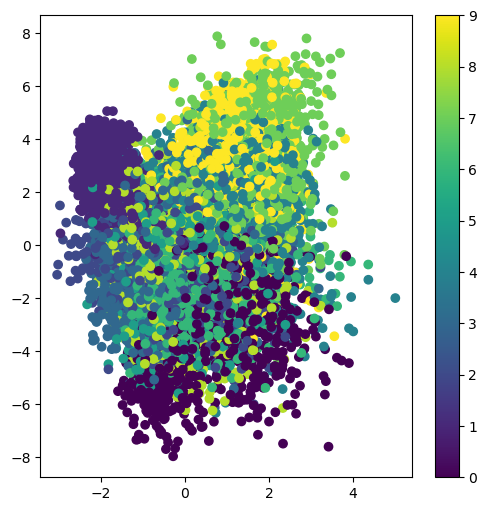

In [7]:
import matplotlib.pyplot as plt

x_test_encoded = np.asarray(encoder.predict(x_test, batch_size=128))

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[0, :, 0], x_test_encoded[0, :, 1], c=y_test)
plt.colorbar()
plt.show()

Each of these colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).



Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.



In [8]:
# Create a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
image = np.zeros((digit_size * n, digit_size * n))

# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        image[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

Now, lets visualize the latent space of the VAE model:

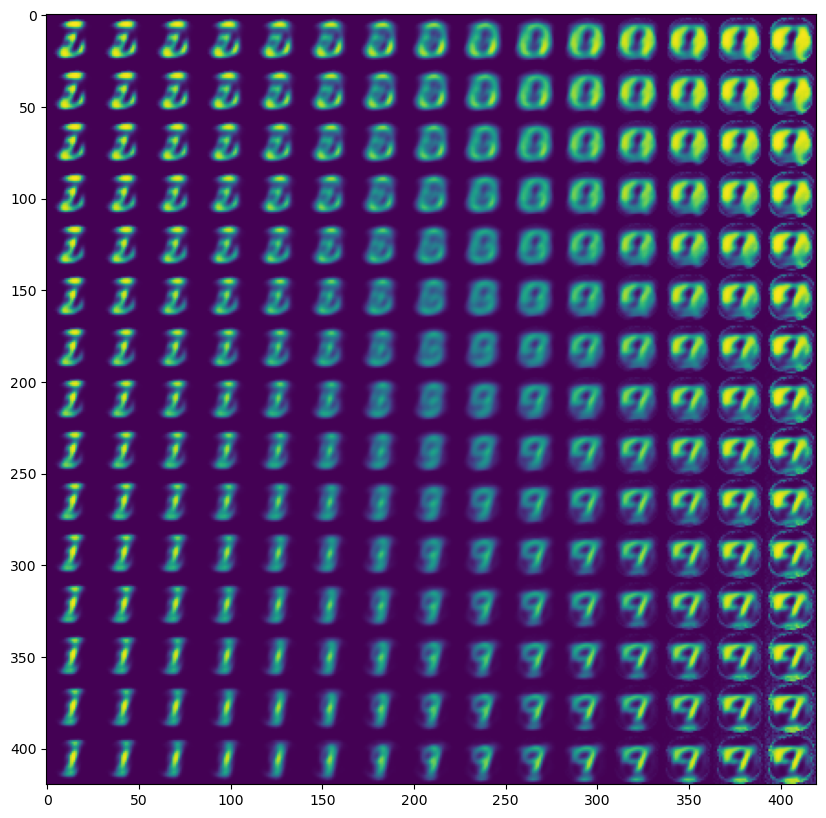

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

### Generative Adversarial Networks

Generative adversarial networks (GANs) are a type of generative model that learn to generate new samples by training two neural networks: a generator and a discriminator. The generator network generates new samples, while the discriminator network tries to distinguish between real and generated samples.


This process is repeated until the generator produces samples that are indistinguishable from real samples. GANs are trained using a min-max game, where the generator tries to fool the discriminator, and the discriminator tries to distinguish between real and generated samples.

### Generative Adversarial Networks

In practice, GANs are trained using a loss function that consists of two terms: a generator loss that measures how well the generator fools the discriminator, and a discriminator loss that measures how well the discriminator distinguishes between real and generated samples:

$$
\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log(1 - D(G(z)))]
$$

Where $p_{\text{data}}(x)$ is the data distribution, $p(z)$ is the prior distribution on the latent space, $D(x)$ is the discriminator output for a real sample $x$, and $G(z)$ is the generator output for a latent sample $z$.

While GANs are powerful generative models, they can be difficult to train and require careful tuning of the hyperparameters. However, they have been used to generate realistic images, text, and music, and have been applied to a wide range of applications, such as image generation, image-to-image translation, and style transfer.

### Other flavors of GANs

There are many different variants of GANs, each with its own architecture and training procedure. Some of the most popular variants include:

- **Conditional GANs**: GANs that generate samples conditioned on some input data, such as class labels or text descriptions.
- **CycleGAN**: GANs that learn to translate images from one domain to another without paired data.
- **StyleGAN**: GANs that learn to generate high-quality images with fine-grained control over the style and content.

<center><img src="_images/stylegan-teaser.png" alt="gan" width="500"/></center>

## The growth of generative models

### Diffusion Models

Another type of generative model that has gained popularity in recent years is diffusion models. Diffusion models are based on the idea of modeling the data distribution as a diffusion process, where the data is gradually transformed from a simple distribution to the target distribution.



The key idea behind diffusion models is to learn a sequence of transformations that map the data from a simple distribution to the target distribution. The transformations are learned using a denoising autoencoder, where the input is a noisy sample and the output is a clean sample.

<center><img src="_images/diffusion_example.gif" alt="diffusion" width="300"/></center>

### Diffusion Models

They're similar to VAEs in that they learn a probabilistic representation of the data, but they're different in that they model the data distribution as a diffusion process rather than a latent space. This means the latent space is less interpretable, but the model can generate high-quality samples by sampling from the learned diffusion process.


### How do Diffusion Models Work?

Diffusion models generate data by gradually transforming random noise into a structured sample, such as an image, through a series of small steps. The process involves two main phases:

1. **Forward Process (Adding Noise):**
    - Starting with a real data sample (like an image), the model adds a small amount of random noise at each step.
    - After many steps, the data becomes nearly pure noise.
    - This process is mathematically defined so that each step (and their product) is predictable and reversible.


![Forward process](_images/forward_diffusion.png)



2. **Reverse Process (Denoising):**
    - The model learns how to reverse the noising process, step by step, turning noise back into a realistic sample.
    - At each step, the model predicts and removes a bit of noise, slowly recovering the structure of the original data.
    - By starting from pure noise and applying the learned denoising steps, the model can generate new, realistic samples.


![Reverse process](_images/reverse_diffusion.png)

### How do Diffusion Models Work?

This approach is powerful because it allows the model to learn complex data distributions in a stable and controllable way. The key idea is that by breaking down the generation process into many small, simple steps, the model can learn to create high-quality, diverse outputs.

The training of diffusion models involves optimizing the model to predict the noise added at each step, effectively learning how to denoise the data. This is done by minimizing a loss function that measures the difference between the predicted noise and the actual noise added during the forward process.


### Diffusion Models in Practice

The loss function used in diffusion models is typically a variant of the mean squared error (MSE) loss, which measures the difference between the predicted noise and the actual noise added during the forward process. The model is trained to minimize this loss, effectively learning how to denoise the data:

$$
\mathcal{L} = \mathbb{E}_{x, t} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]
$$

Where $x_t$ is the noisy sample at time step $t$, $\epsilon$ is the actual noise added, and $\epsilon_\theta(x_t, t)$ is the predicted noise by the model.




A key component of diffusion models is the noise schedule, which defines how much noise is added at each step of the forward process. The noise schedule can be linear, cosine, or learned, and it plays a crucial role in the quality of the generated samples.


### Diffusion Models in Practice

There are several popular diffusion models, including:
- **DDPM (Denoising Diffusion Probabilistic Models)**: A foundational diffusion model that introduced the concept of diffusion-based generation.
- **Score-Based Generative Models**: These models use score matching to learn the data distribution and generate samples by sampling from the learned score function.
- **Latent Diffusion Models (LDMs)**: These models operate in a lower-dimensional latent space, making them more efficient and capable of generating high-resolution samples.


### Climate Diffusion Models

I'm also excited about using diffusion models for sampling weather states from climate models:

<center><img src="_images/climate_diffusion.png" alt="diffusion" width="900"/></center>


## Conclusion

We've covered a lot of ground in this lecture, discussing generative models, variational autoencoders, generative adversarial networks, and diffusion models. These models have been used in a wide range of applications, such as image generation, text generation, and music generation.



Generative models are a powerful class of machine learning models that learn the underlying distribution of the data and generate new samples from the learned distribution. They have been used in a wide range of applications and have the potential to revolutionize the way we generate new data samples.



They have not been widely used in the geosciences yet, but given the potential for generating new data samples and learning (spatio-temporal) representations of complex geospatial data, they could be very important in the near future.